# Mango Leaf Disease Classification
This notebook demonstrates the training of a convolutional neural network (CNN) to classify mango leaf diseases. The dataset is assumed to be located in a directory named `mango`, with subdirectories for each class representing different diseases (or healthy leaves).


In [1]:
import os
import PIL
import shutil
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, save_model


## Dataset Preparation
Using a custom dataset located in the `mango` directory. The dataset must follow the required directory structure, where each class has its own subdirectory.


In [3]:
# Replace this with the path to your mango dataset directory
data_dir = pathlib.Path("./mango")

# Count the number of images
image_count = len(list(data_dir.glob('*/*.jpg')))
print("Total number of images:", image_count)


Total number of images: 1500


## Loading Data
The data is divided into training and validation sets. 80% of the images are used for training, and 20% are reserved for validation.


In [4]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # Use 20% of data for validation
    subset="training",
    seed=123,  # Seed for reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 1500 files belonging to 3 classes.
Using 1200 files for training.
Found 1500 files belonging to 3 classes.
Using 300 files for validation.


## Class Names
The classes are automatically inferred from the subdirectory names in the dataset.


In [5]:
class_names = train_ds.class_names
print("Class Names:", class_names)


Class Names: ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil']


## Optimizing Dataset Performance
Cache the datasets to memory and shuffle the training dataset to improve performance during training.

In [6]:
train_ds = train_ds.cache().shuffle(1000)
val_ds = val_ds.cache()


## Building the Model
The model is a convolutional neural network with three convolutional layers, max pooling, and dense layers for classification.


In [7]:
num_classes = len(class_names)

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Training the Model
Train the model for 10 epochs and validate its performance on the validation dataset.


In [8]:
epochs = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

print("Training Complete!")


Epoch 1/20
38/38 [==============================] - 13s 292ms/step - loss: 0.8713 - accuracy: 0.6642 - val_loss: 0.4409 - val_accuracy: 0.6900
Epoch 2/20
38/38 [==============================] - 10s 260ms/step - loss: 0.1586 - accuracy: 0.9425 - val_loss: 0.1333 - val_accuracy: 0.9800
Epoch 3/20
38/38 [==============================] - 9s 251ms/step - loss: 0.0468 - accuracy: 0.9883 - val_loss: 0.1175 - val_accuracy: 0.9800
Epoch 4/20
38/38 [==============================] - 9s 244ms/step - loss: 0.0846 - accuracy: 0.9733 - val_loss: 0.1264 - val_accuracy: 0.9800
Epoch 5/20
38/38 [==============================] - 9s 243ms/step - loss: 0.0752 - accuracy: 0.9733 - val_loss: 0.1918 - val_accuracy: 0.9500
Epoch 6/20
38/38 [==============================] - 9s 249ms/step - loss: 0.0377 - accuracy: 0.9858 - val_loss: 0.0923 - val_accuracy: 0.9933
Epoch 7/20
38/38 [==============================] - 12s 308ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0974 - val_accuracy: 0.9933
Epo

## Visualizing Training Results
The training and validation accuracy and loss are plotted to analyze the model's performance.


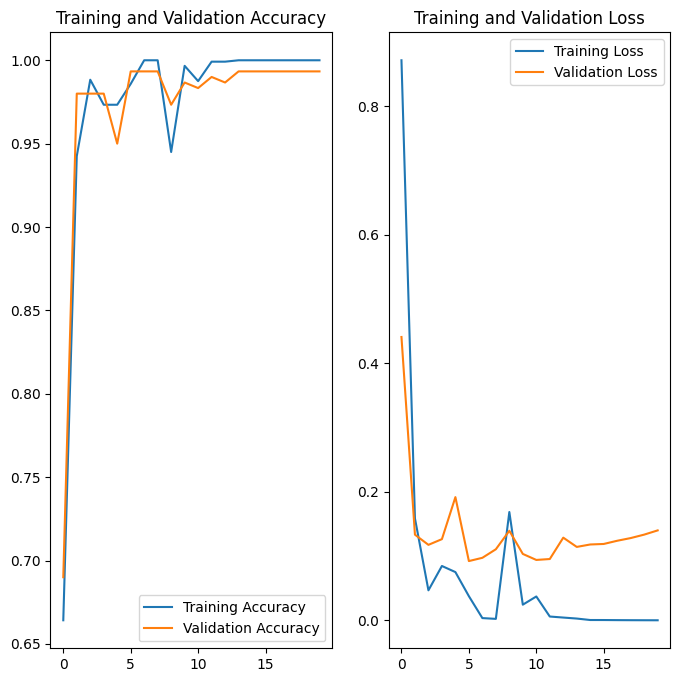

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Saving the Model
Save the trained model to a file for later use.


In [10]:
# Load the saved model from the file
model = tf.keras.models.load_model('mango_leaf_disease_model.h5')
print("Model loaded!")


Model loaded!
